In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline
from tqdm.auto import tqdm
from safetensors.torch import load_file

In [2]:
def load_model():
 pipeline = ChronosPipeline.from_pretrained(
 "amazon/chronos-t5-small",
 device_map="cuda", 
 torch_dtype=torch.bfloat16,
 )
 return pipeline

def load_finetuned_model():
    model_path = r"C:\Users\jornv\OneDrive\Documenten\Projects\Crypto\chronos-forecasting\scripts\output\run-21\checkpoint-final\model.safetensors"
    config_path = r"C:\Users\jornv\OneDrive\Documenten\Projects\Crypto\chronos-forecasting\scripts\output\run-21\checkpoint-final"  # The directory where the model config is saved
    
    # Load the model weights from the safetensors file
    state_dict = load_file(model_path)
    
    # Load the model configuration and set the state_dict
    pipeline = ChronosPipeline.from_pretrained(
        config_path,  # Path to your model configuration directory
        state_dict=state_dict,
        device_map="cuda", 
        torch_dtype=torch.bfloat16,
    )
    
    return pipeline
    
def predict(pipeline, timeseries, prediction_length=12):
 """given a timeseries, predict with chronos model"""
 forecast = pipeline.predict(timeseries, prediction_length, num_samples=1)[0][0]  # shape [num_series, num_samples, prediction_length]
 return forecast

def visualize(timeseries, forecast, ground_truth=None, xlim=None, ylim=None):
 # visualize the forecast
 assert isinstance(timeseries, torch.Tensor) and isinstance(forecast, torch.Tensor), "timeseries and forecast should be numpy arrays"
 
 plt.figure(figsize=(8, 4))
 plt.plot(range(len(timeseries)), timeseries, color="royalblue", label="historical data")
 plt.plot(range(len(timeseries)-1, len(timeseries) - 1 + len(forecast)), forecast, color="tomato", label="forecast")
 if ground_truth is not None:
  plt.plot(range(len(timeseries)-1, len(timeseries) - 1 + len(ground_truth)), ground_truth, color="green", label="ground truth")
 if xlim is not None:
  plt.xlim(xlim)
 if ylim is not None:
  plt.ylim(ylim)
 plt.legend()
 plt.grid()
 plt.show()

def get_mse(y_true, y_pred):
 return np.mean((y_true - y_pred)**2)
def get_mae(y_true, y_pred):
 return np.mean(np.abs(y_true - y_pred))
def get_rmse(y_true, y_pred):
 return np.sqrt(get_mse(y_true, y_pred))

def get_scores(y_true, y_pred):
 """given true and predicted values, return mse, mae, rmse"""
 return get_mse(y_true, y_pred), get_mae(y_true, y_pred), get_rmse(y_true, y_pred)

In [3]:
crypto_data = pd.read_csv(r"C:/Users/jornv/OneDrive/Documenten/Projects/Crypto/Prepared_data/Firstrate_data_30min/BTC_full_30min.txt", 
                                       header = 0
                                      )

crypto_data = crypto_data.astype({'datetime': 'datetime64[s]'})
crypto_data.sort_values(by = 'datetime', ascending = True)
crypto_data = crypto_data[crypto_data['datetime'] >= '2022-01-01'].copy()
print(crypto_data)

                  datetime       open      high       low     close    volume
152261 2022-01-01 00:00:00  46211.240  46504.00  46150.00  46359.09  647.7200
152262 2022-01-01 00:30:00  46359.100  46744.99  46334.08  46656.85  445.1250
152263 2022-01-01 01:00:00  46656.850  46932.20  46551.90  46800.00  614.1650
152264 2022-01-01 01:30:00  46803.110  46895.14  46719.81  46778.00  375.4160
152265 2022-01-01 02:00:00  46791.692  46936.00  46768.85  46827.17  339.0780
...                    ...        ...       ...       ...       ...       ...
184939 2023-11-12 21:30:00  37160.000  37209.60  37123.00  37172.32  225.1313
184940 2023-11-12 22:00:00  37172.320  37214.25  37130.00  37169.21  117.7434
184941 2023-11-12 22:30:00  37169.600  37176.00  37121.00  37169.80  102.0441
184942 2023-11-12 23:00:00  37168.900  37222.04  36929.00  37048.18  363.1311
184943 2023-11-12 23:30:00  37050.000  37095.74  36918.70  37068.62  431.8255

[32683 rows x 6 columns]


In [4]:
pipeline = load_model()
pipeline_finetuned = load_finetuned_model()

C:\Users\jornv\anaconda3\envs\tradingbot\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
timeseries = crypto_data["close"].to_numpy()

In [6]:
len(timeseries)

32683

In [7]:
# now test the model. Given the last x values, predict the next y values, then we can calculate metrics like MSE, RMSE, MAE
CONTEXT_LENGTH = 40
PREDICTION_LENGTH = 10


mse_scores, mae_scores, rmse_scores = [], [], []
mse_scores_ft, mae_scores_ft, rmse_scores_ft = [], [], []
indices_with_spikes = []
for i in tqdm(range(0, len(timeseries), 322)):
    if (i+CONTEXT_LENGTH+PREDICTION_LENGTH) > len(timeseries):
        break
    ground_truth = timeseries[i+CONTEXT_LENGTH:i+CONTEXT_LENGTH+PREDICTION_LENGTH]
    
    prediction = predict(pipeline, torch.tensor(timeseries[i:i+CONTEXT_LENGTH]), PREDICTION_LENGTH)
    mse, mae, rmse = get_scores(ground_truth, prediction.numpy())
    mse_scores.append(mse), mae_scores.append(mae), rmse_scores.append(rmse)
    
    prediction_finetuned = predict(pipeline_finetuned, torch.tensor(timeseries[i:i+CONTEXT_LENGTH]), PREDICTION_LENGTH)
    mse, mae, rmse = get_scores(ground_truth, prediction_finetuned.numpy())
    mse_scores_ft.append(mse), mae_scores_ft.append(mae), rmse_scores_ft.append(rmse)

    # Check for spikes
    if mse > np.percentile(mse_scores, 75) + 1.5 * (np.percentile(mse_scores, 75) - np.percentile(mse_scores, 25)):
        indices_with_spikes.append(i)

  0%|          | 0/102 [00:00<?, ?it/s]

In [8]:
spike_rows = crypto_data.iloc[indices_with_spikes * 322]

In [9]:
print(spike_rows)

                  datetime      open      high       low     close     volume
153227 2022-01-21 03:00:00  39838.35  39956.00  38731.00  38967.08  3194.0942
157091 2022-04-11 15:00:00  40810.92  41015.00  40771.64  40802.46   432.6627
173513 2023-03-19 20:30:00  28053.00  28137.41  27733.00  27974.32  1206.4288
173835 2023-03-26 13:30:00  27918.30  28240.40  27908.00  28186.55  1234.1422
179953 2023-08-01 00:30:00  29240.24  29320.00  29228.30  29281.03   199.0180
...                    ...       ...       ...       ...       ...        ...
153227 2022-01-21 03:00:00  39838.35  39956.00  38731.00  38967.08  3194.0942
157091 2022-04-11 15:00:00  40810.92  41015.00  40771.64  40802.46   432.6627
173513 2023-03-19 20:30:00  28053.00  28137.41  27733.00  27974.32  1206.4288
173835 2023-03-26 13:30:00  27918.30  28240.40  27908.00  28186.55  1234.1422
179953 2023-08-01 00:30:00  29240.24  29320.00  29228.30  29281.03   199.0180

[1610 rows x 6 columns]


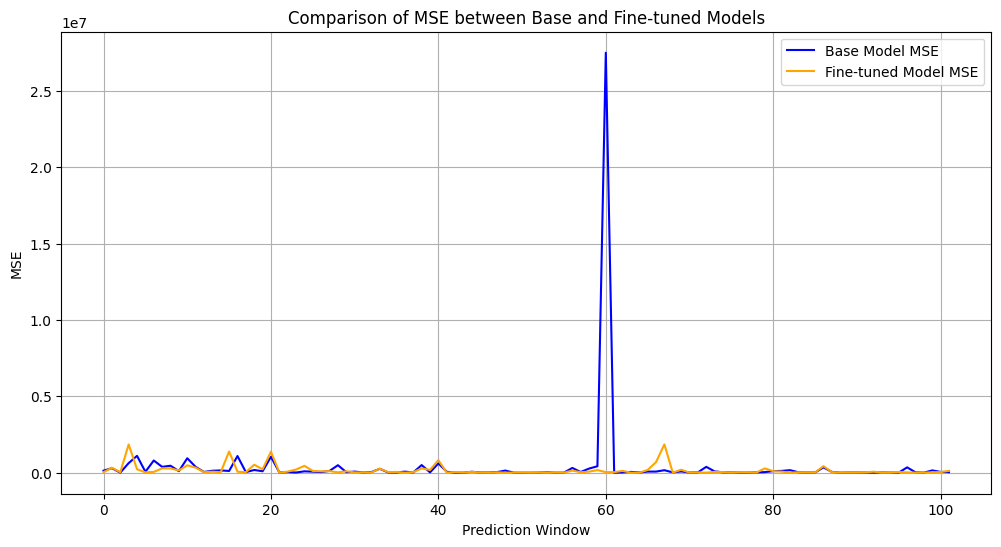

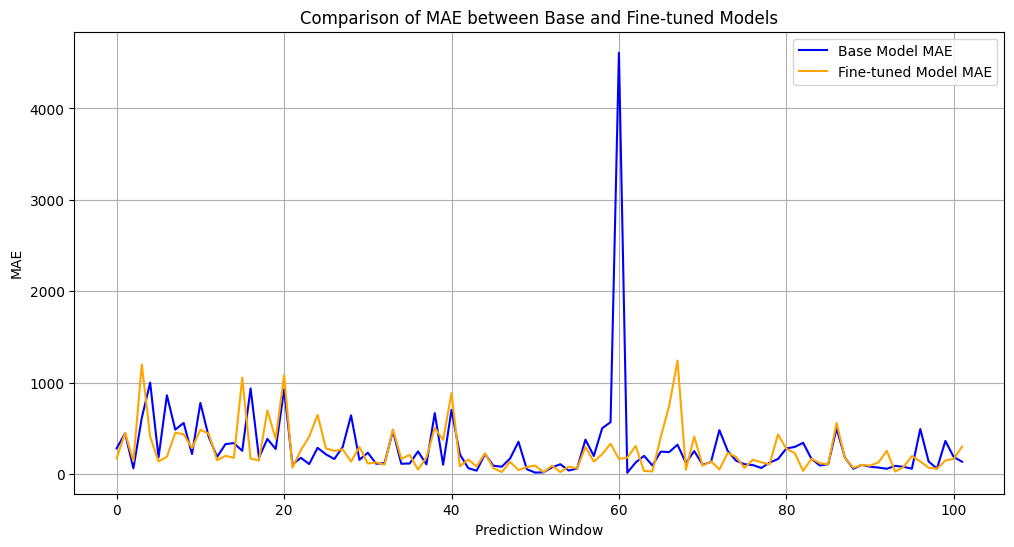

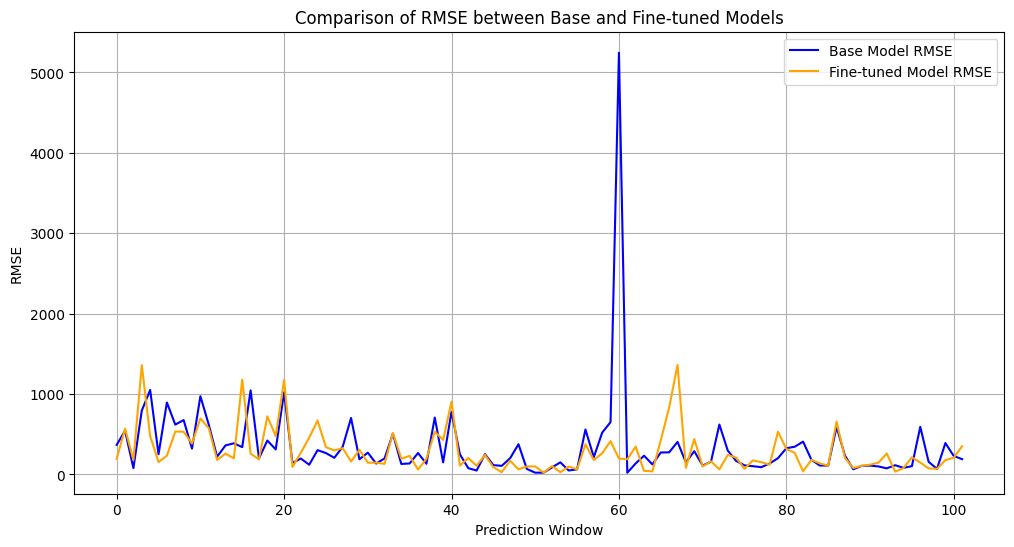

In [10]:
# Plotting the results
def plot_scores(base_scores, finetuned_scores, score_name):
    plt.figure(figsize=(12, 6))
    plt.plot(base_scores, label=f"Base Model {score_name}", color="blue")
    plt.plot(finetuned_scores, label=f"Fine-tuned Model {score_name}", color="orange")
    plt.xlabel("Prediction Window")
    plt.ylabel(score_name)
    plt.title(f"Comparison of {score_name} between Base and Fine-tuned Models")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot MSE, MAE, and RMSE
plot_scores(mse_scores, mse_scores_ft, "MSE")
plot_scores(mae_scores, mae_scores_ft, "MAE")
plot_scores(rmse_scores, rmse_scores_ft, "RMSE")

In [11]:
np.mean(mse_scores), np.mean(mae_scores), np.mean(rmse_scores), np.mean(mse_scores_ft), np.mean(mae_scores_ft), np.mean(rmse_scores_ft)

(416066.9145659162,
 295.5504868125559,
 344.33541286697385,
 158370.17338680723,
 253.07943706991995,
 289.5288078336232)